# 3A. DATA PRE-PROCESSING ON `SELF-CRAWL DATASET`

## Import libraries

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import shutil
import stat
import re
import warnings
# Suppress warnings
warnings.filterwarnings('ignore')

In [2]:
input_folder = '../data/raw_photos'
output_folder = '../data/processed_photos'
os.makedirs(output_folder, exist_ok=True)

## Merge the folders divided among members into a unified folder

### Handle folder `data/raw_photos`

In [3]:
def remove_readonly(func, path, exc_info):
    os.chmod(path, stat.S_IWRITE)
    func(path)

# Move images from subfolders of data\raw_photos to data\raw_photos and remove those subfolders
for subfolder in tqdm(os.listdir(input_folder)):
    subfolder_path = os.path.join(input_folder, subfolder)

    if os.path.isdir(subfolder_path):
        for file in os.listdir(subfolder_path):
            file_path = os.path.join(subfolder_path, file)
            shutil.move(file_path, input_folder)
        shutil.rmtree(subfolder_path, onerror=remove_readonly)

print("✅ Moved images from subfolders to data/raw_photos")

100%|██████████| 4/4 [00:04<00:00,  1.01s/it]

✅ Moved images from subfolders to data/raw_photos


In [4]:
n_images = len([name for name in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, name))])
print(f"Number of images in the input folder: {n_images}")

Number of images in the input folder: 1077


### Handle folder `data/annotations`

In [5]:
annotations_folder = '../data/annotations'

pattern = re.compile(r'captions_.*_cleaned\.txt')

for file in os.listdir(annotations_folder):
    if pattern.match(file):
        file_path = os.path.join(annotations_folder, file)
        if os.path.exists(file_path):
            os.remove(file_path)
            print(f"✅ Removed {file_path}")
        else:
            print(f"❌ {file_path} does not exist")

✅ Removed ../data/annotations\captions_L_cleaned.txt
✅ Removed ../data/annotations\captions_Q_cleaned.txt
✅ Removed ../data/annotations\captions_T_cleaned.txt
✅ Removed ../data/annotations\captions_V_cleaned.txt


### Adjust format captions to synchronize UIT dataset

In [ ]:
# Save map to rename image files from Archery_1.jpg to the pattern 000000566746.jpg
map = {}
for i, file in enumerate(os.listdir(input_folder)):
    map[file] = f"{i + 100000000000:012d}.jpg"

In [4]:
def convert_format_caption(input_path):
    # Convert format of captions from '<path>, <caption>' to '<path>\t<caption>'
    with open(input_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    output_lines = []
    for line in lines:
        line = line.strip()
        if not line:  # Skip empty lines
            continue

        comma_pos = line.find(',')
        if comma_pos == -1:
            print(f"❌ Invalid line: {line}")
            continue

        path = line[:comma_pos].strip()
        caption = line[comma_pos+1:].strip()

        path = map[path]
        new_line = f"{path}\t{caption}"
        output_lines.append(new_line)

    with open(input_path, 'w', encoding='utf-8') as f:
        f.write('\n'.join(output_lines))
    
    print(f"✅ Converted format of captions in {input_path}")

In [6]:
convert_format_caption('../data/annotations/captions.txt')

✅ Converted format of captions in ../data/annotations/captions.txt


## Pre-processing

1. Remove corrupted, blurry, or irrelevant images **manually**

2. Convert to the same format (jpg), same size

In [7]:
TARGET_SIZE = 448

In [8]:
def resize_with_padding(image_path, target_size=224):
    img = Image.open(image_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')

    width, height = img.size

    # Ensure the longest side is target_size
    if width >= height:
        # Nếu chiều rộng là cạnh dài nhất
        new_width = target_size
        new_height = int(height * (target_size / width))
    else:
        # Nếu chiều cao là cạnh dài nhất
        new_height = target_size
        new_width = int(width * (target_size / height))

    resized_img = img.resize((new_width, new_height), Image.LANCZOS)

    return resized_img

def preprocess_images(input_folder, output_folder):
    for filename in tqdm(os.listdir(input_folder)):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, map[filename])

        try:
            # Resize image with padding
            img = resize_with_padding(input_path, target_size=TARGET_SIZE)

            # Save image as JPG
            img.save(output_path, "JPEG", quality=95)

        except Exception as e:
            print(f"❌ Error processing {input_path}: {e}")

In [9]:
preprocess_images(input_folder, output_folder)
print(f"✅ Processed {len(os.listdir(output_folder))} images")

 19%|█▊        | 201/1077 [00:11<00:52, 16.73it/s]

❌ Error processing ../data/raw_photos\captions.txt: cannot identify image file '../data/raw_photos\\captions.txt'


100%|██████████| 1077/1077 [00:56<00:00, 19.08it/s]

✅ Processed 1076 images


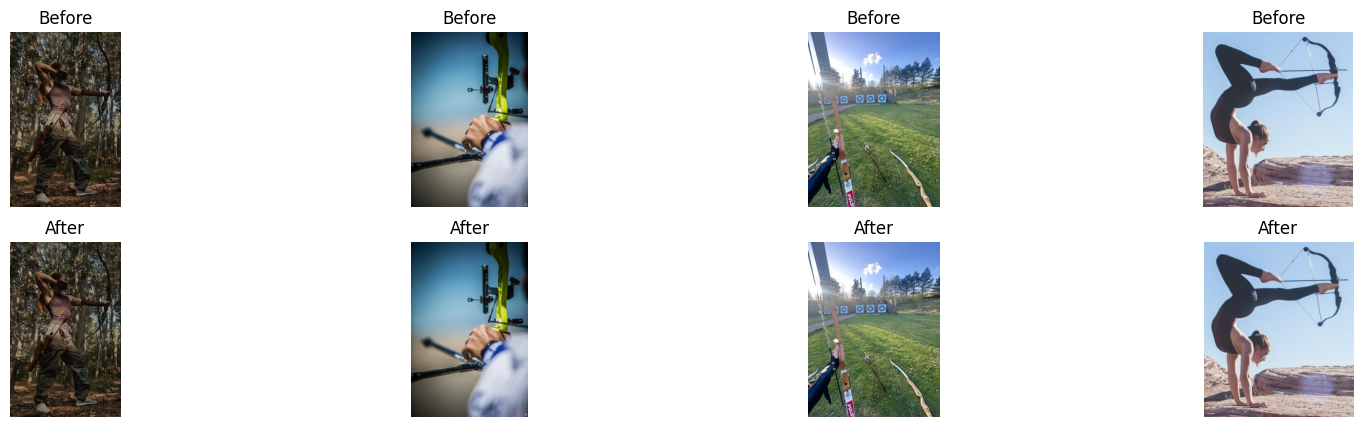

In [11]:
# Show some images before and after preprocessing
n_images_to_show = 4
fig, axes = plt.subplots(2, n_images_to_show, figsize=(20, 5))

for i, filename in enumerate(os.listdir(input_folder)[:n_images_to_show]):
    img = Image.open(os.path.join(input_folder, filename))
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    axes[0, i].set_title("Before")

for i, filename in enumerate(os.listdir(output_folder)[:n_images_to_show]):
    img = Image.open(os.path.join(output_folder, filename))
    axes[1, i].imshow(img)
    axes[1, i].axis('off')
    axes[1, i].set_title("After")

plt.show()

Ok! do not need GAN...

# 3B. DATA PRE-PROCESSING ON `UIT DATASET`

Merge `test`, `train` and `valid`

In [3]:
test_caption_path = '../data/UIT-ViIC/dataset/test/captions.txt'
train_caption_path = '../data/UIT-ViIC/dataset/train/captions.txt'
val_caption_path = '../data/UIT-ViIC/dataset/val/captions.txt'

In [4]:
merged_caption_path = '../data/UIT-ViIC/captions.txt'

with open(merged_caption_path, 'w', encoding='utf-8') as outfile:
    for caption_path in [test_caption_path, train_caption_path, val_caption_path]:
        with open(caption_path, 'r', encoding='utf-8') as infile:
            outfile.write(infile.read() + '\n')

print(f"✅ Merged captions into {merged_caption_path}")

✅ Merged captions into ../data/UIT-ViIC/captions.txt


Change format `/path/to/000000375321.jpg   Caption text.` into  `000000375321.jpg   Caption text.`

In [5]:
def extract_filename_caption(caption_path, output_path=None):
    with open(caption_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    converted_lines = []
    for line in lines:
        line = line.strip()
        if not line:
            continue

        parts = re.split(r'\t|\s{2,}', line, maxsplit=1)
        if len(parts) < 2:
            print(f"❌ Invalid line: {line}")
            continue

        path, caption = parts[0].strip(), parts[1].strip()

        filename = os.path.basename(path)

        new_line = f"{filename}\t{caption}"
        converted_lines.append(new_line)

    if output_path:
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        
        with open(output_path, 'w', encoding='utf-8') as outfile:
            outfile.write('\n'.join(converted_lines))
        
        print(f"✅ Successfully converted {len(converted_lines)} lines.")
        print(f"✅ Results have been saved to: {output_path}")
    
    return converted_lines

In [6]:
extract_filename_caption(merged_caption_path, merged_caption_path)

✅ Successfully converted 19256 lines.
✅ Results have been saved to: ../data/UIT-ViIC/captions.txt


['000000205086.jpg\tMột cậu bé đang chống đẩy trên quả banh.',
 '000000205086.jpg\tMột cậu bé đang chống đầu lên quả bóng đá hít đất.',
 '000000205086.jpg\tMột cậu bé đang hít đất đầu trên quả banh trên cỏ.',
 '000000205086.jpg\tMột cậu bé đang hít đất cùng quả bóng và một cậu bé đang quan sát.',
 '000000205086.jpg\tMột cậu bé đang chống đẩy trên một quả bóng đá.',
 '000000304473.jpg\tMột vận động viên bóng chày nữ đang ném quả bóng chày.',
 '000000304473.jpg\tNgười phụ nữ vừa ném quả bóng chày về phía trước.',
 '000000304473.jpg\tCầu thủ bóng chày nữ đang vừa chạy vừa ném quả bóng',
 '000000304473.jpg\tNgười phụ nữ đang chạy trên sân tay ném bóng.',
 '000000304473.jpg\tNgười phụ nữ đang ném quả bóng về phía trước.',
 '000000123697.jpg\tMột poster có nhiều hình ảnh của nhiều lĩnh vực',
 '000000123697.jpg\tMột bức poster quảng cáo về nhiều thể loại',
 '000000123697.jpg\tMột trang bìa có nhiều ô vuông chứa nhiều hình ảnh khác nhau.',
 '000000123697.jpg\tNhiều bức tranh với nhiều lĩnh vực

Merge image folders from `test`, `valid`, `train` into one 

In [7]:
test_img_path = '../data/UIT-ViIC/dataset/test/images'
train_img_path = '../data/UIT-ViIC/dataset/train/images'
val_img_path = '../data/UIT-ViIC/dataset/val/images'

In [8]:
merged_img_path = '../data/UIT-ViIC/images'
os.makedirs(merged_img_path, exist_ok=True)

for img_path in [test_img_path, train_img_path, val_img_path]:
    for filename in tqdm(os.listdir(img_path)):
        src_path = os.path.join(img_path, filename)
        dst_path = os.path.join(merged_img_path, filename)
        shutil.copy(src_path, dst_path)

print(f"✅ Merged images into {merged_img_path}")

100%|██████████| 924/924 [00:02<00:00, 371.28it/s]

✅ Merged images into ../data/UIT-ViIC/images


## Merge `self-crawl dataset` and `UIT-ViIC`

In [9]:
# Create folder US-Capydata-ViSportIC
visportic_folder = '../data/US-Capydata-ViSportIC'
os.makedirs(visportic_folder, exist_ok=True)

Merge captions

In [10]:
self_crawl_caption_path = '../data/annotations/captions.txt'
uit_caption_path = '../data/UIT-ViIC/captions.txt'

In [11]:
merged_caption_path = os.path.join(visportic_folder, 'captions.txt')
with open(merged_caption_path, 'w', encoding='utf-8') as outfile:
    for caption_path in [self_crawl_caption_path, uit_caption_path]:
        with open(caption_path, 'r', encoding='utf-8') as infile:
            outfile.write(infile.read() + '\n')

Merge images folder

In [12]:
self_crawl_img_path = '../data/processed_photos'
uit_img_path = '../data/UIT-ViIC/images'

In [13]:
merged_img_path = os.path.join(visportic_folder, 'images')
os.makedirs(merged_img_path, exist_ok=True)
for img_path in [self_crawl_img_path, uit_img_path]:
    for filename in tqdm(os.listdir(img_path)):
        src_path = os.path.join(img_path, filename)
        dst_path = os.path.join(merged_img_path, filename)
        shutil.copy(src_path, dst_path)

print(f"✅ Merged images into {merged_img_path}")

100%|██████████| 3850/3850 [00:08<00:00, 443.75it/s]

✅ Merged images into ../data/US-Capydata-ViSportIC\images


Split file to `train`, `test` and `valid` with ratio 70:15:15

In [14]:
import random
from pathlib import Path

dataset_dir = Path("../data/US-Capydata-ViSportIC")
dataset_output = dataset_dir / "dataset"
image_dir = dataset_dir / "images"
caption_file = dataset_dir / "captions.txt"

In [15]:
for split in ["train", "val", "test"]:
    (dataset_output / split / "images").mkdir(parents=True, exist_ok=True)

In [16]:
# Read caption file
with open(caption_file, "r", encoding="utf-8") as f:
    lines = f.readlines()

# Group captions by image name
caption_dict = {}
for line in lines:
    parts = line.strip().split("\t")
    if len(parts) == 2:
        image_name, caption = parts
        if image_name not in caption_dict:
            caption_dict[image_name] = []
        caption_dict[image_name].append(caption)

# List of image files
image_files = list(caption_dict.keys())
random.shuffle(image_files)  # Shuffle images but keep grouped captions

# Split dataset into train, val, test (70%, 15%, 15%)
total = len(image_files)
train_split = int(0.7 * total)
val_split = int(0.15 * total)

train_files = image_files[:train_split]
val_files = image_files[train_split:train_split + val_split]
test_files = image_files[train_split + val_split:]

In [17]:
# Rewrite follow sample of UIT-ViIC dataset `/dataset/train/images/000000566746.jpg	Đội bóng đá đang chơi trên sân cỏ xanh``
for split, files in zip(["train", "val", "test"], [train_files, val_files, test_files]):
    output_caption_file = dataset_output / split / "captions.txt"
    with open(output_caption_file, "w", encoding="utf-8") as f:
        for file in files:
            for caption in caption_dict[file]:
                f.write(f"/dataset/{split}/images/{file}\t{caption}\n")

In [18]:
# Split image into train, val, test respectively
for split, files in zip(["train", "val", "test"], [train_files, val_files, test_files]):
    for file in files:
        src_path = image_dir / file
        dst_path = dataset_output / split / "images" / file
        shutil.copy(src_path, dst_path)

print("✅ Dataset split and captions saved successfully.")

✅ Dataset split and captions saved successfully.


## NORMALIZED

In [1]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import os
import re
import unicodedata
from pyvi import ViTokenizer

In [2]:
train_img_path = '../data/US-Capydata-ViSportIC/dataset/train/images'
val_img_path = '../data/US-Capydata-ViSportIC/dataset/val/images'
test_img_path = '../data/US-Capydata-ViSportIC/dataset/test/images'

train_caption_path = '../data/US-Capydata-ViSportIC/dataset/train/captions.txt'
val_caption_path = '../data/US-Capydata-ViSportIC/dataset/val/captions.txt'
test_caption_path = '../data/US-Capydata-ViSportIC/dataset/test/captions.txt'

### Normalize image features

In [3]:
train_output_path = '../data/US-Capydata-ViSportIC/normalized_dataset/train/images'
val_output_path = '../data/US-Capydata-ViSportIC/normalized_dataset/val/images'
test_output_path = '../data/US-Capydata-ViSportIC/normalized_dataset/test/images'

os.makedirs(train_output_path, exist_ok=True)
os.makedirs(val_output_path, exist_ok=True)
os.makedirs(test_output_path, exist_ok=True)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), # to [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
def normalize_images(input_path, output_path, transform):
    for filename in os.listdir(input_path):
        img = Image.open(os.path.join(input_path, filename)).convert('RGB')
        img = transform(img)
        torch.save(img, os.path.join(output_path, os.path.splitext(filename)[0] + '.pt'))

    print(f"✅ Normalized {len(os.listdir(output_path))} images")

normalize_images(train_img_path, train_output_path, transform)
normalize_images(val_img_path, val_output_path, transform)
normalize_images(test_img_path, test_output_path, transform)

✅ Normalized 3448 images
✅ Normalized 736 images
✅ Normalized 740 images


### Normalized caption text

In [6]:
train_caption_output_path = '../data/US-Capydata-ViSportIC/normalized_dataset/train/captions.txt'
val_caption_output_path = '../data/US-Capydata-ViSportIC/normalized_dataset/val/captions.txt'
test_caption_output_path = '../data/US-Capydata-ViSportIC/normalized_dataset/test/captions.txt'

In [7]:
def clean_text(text):
    # Remove unnecessary punctuation (keep hyphen for compound words)
    text = re.sub(r"[!\"#$%&'()*+,./:;<=>?@[\\]^_`{|}~]", " ", text)
    # Norm Vietnamese text
    text = unicodedata.normalize("NFC", text)
    # To lowercase
    text = text.lower()
    # Keep only Vietnamese characters, digits, and hyphen
    text = re.sub(r"[^a-zA-Z0-9À-Ỹà-ỹ\s-]", "", text)
    # Remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()
    # Tokenize 
    text = ViTokenizer.tokenize(text)

    # Add <startseq> and <endseq> to the text
    text = f"<s> {text} <\s>"
    return text

<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
C:\Users\mtue2\AppData\Local\Temp\ipykernel_10736\1332756573.py:16: SyntaxWarning: invalid escape sequence '\s'
  text = f"<s> {text} <\s>"


In [8]:
# Normalize captions
def normalize_captions(input_path, output_path):
    with open(input_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    output_lines = []
    for line in lines:
        parts = line.strip().split('\t')
        if len(parts) != 2:
            print(f"❌ Invalid line: {line}")
            continue

        filename, caption = parts
        caption = clean_text(caption)
        new_line = f"{filename}\t{caption}"
        output_lines.append(new_line)

    with open(output_path, 'w', encoding='utf-8') as f:
        f.write('\n'.join(output_lines))

    print(f"✅ Normalized {len(output_lines)} captions")

normalize_captions(train_caption_path, train_caption_output_path)
normalize_captions(val_caption_path, val_caption_output_path)
normalize_captions(test_caption_path, test_caption_output_path)

✅ Normalized 17257 captions
✅ Normalized 3680 captions
✅ Normalized 3696 captions
